# Clasificador polen (Telmu) a partir de una red pre-entrenada:

### GPU disponible:

In [1]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.13.1
Default GPU Device: /device:GPU:0


### Modelo VGG16:

In [2]:
import sys
import os
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers import  Convolution2D, MaxPooling2D, Dense, GlobalAveragePooling2D, AveragePooling2D
from keras.models import Model
from keras import backend as K
from keras import applications
K.clear_session()

Using TensorFlow backend.


Se carga el modelo InceptionResNetV2: 

keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)

Este modelo contiene los pesos obtenidos con el pre-entrenamiento en ImageNet. Por defecto, establece una imagen de entrada de 299x299.

In [3]:
baseModel = applications.vgg16.VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))#Cargamos la red
baseModel.summary()#Muestra el contenido de la red.

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
bloc

Se ha pasado como argumento include_top=False. La red VGG16 que aporta keras contiene por defecto una última capa de predicción de mil neuronas (para clasificar mil clases diferentes). La red que se busca solo clasificará dos clases diferentes. Con include_top=False se elimina esta última capa. En la siguiente línea de código se carga la red al completo:

### Modificación de la última capa:

Se diseña la capa de salida para realizar la clasificación. Constará de:

Capa GlobalAveragePooling2D.

Capa tipo Dense de 1000 neuronas y activación rectificador (relu)

In [4]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="softmax")(headModel)

# add a global spatial average pooling layer
#x = InceptionResNetV2.output
#x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
#x = Dense(800, activation='relu')(x)
#To reduce overfitting...
#x = Dropout(0.5)(x)
# and a logistic layer -- let's say we have 3 classes
#predictions = Dense(2, activation='softmax')(x)
#model = Model(inputs=InceptionResNetV2.input, outputs=predictions)

model = Model(inputs=baseModel.input, outputs=headModel)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [ ]:
model.layers

### Congelación de capas:

Se ha cargado la red pre-entrenada InceptionResNetV2, con los pesos de Imagenet. De esta forma las capas convolucionales y pooling que la forman actuarán como diferenciadoras de características, que serán usadas por la capa final que se ha incluido para realizar la clasificación.

Por tanto, se va a usar una red que ya ha 'aprendido' a clasificar en otros problemas, y se va a adaptar para el problema que aquí se trata (TRANSFER LEARNING).

Es por esto que no es necesario entrenar todas las capas de la red, y solo se entrenarán las 3 capas que se han añadido, congelando las demás.

In [6]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 average_pooling2d_1
20 flatten
21 dense_1
22 dropout_1
23 dense_2


In [7]:
#for layer in model.layers[:780]:
#   layer.trainable = False
#for layer in model.layers[780:]:
#   layer.trainable = True
for layer in baseModel.layers:
    layer.trainable = False

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

### Tratamiento de las imágenes:

Se necesita adaptar el conjunto de imágenes para poder ser tratado por el modelo. Para ello se van a usar las funciones flow_from_directory() y ImageDataGenerator().

In [16]:
#Se almacenan en variables los directorios en los que se encuentran las imágenes
data_entrenamiento = './data_polen/entrenamiento'
data_validacion = './data_polen/validacion'

#Parámetros importantes:
epocas=50
longitud, altura = 256, 256
batch_size = 32 #Imágenes a procesar en cada paso
pasos = 10
clases = 2
lr = 1e-4 #Learning rate
momentum = 0.9

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest')

Con la función flow_from_directory() se pre-procesan las imágenes que se encuentran en los directorios previamente declarados. Además se le puede pasar como parámetros el tamaño al que se redimensionan las imágenes, o el algoritmo de interpolación.

keras.preprocessing.image.ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None)

Gracias a la función ImageDataGenerator() se aplica al set de entrenamiento mecanismos de DATA ARGUMENTATION como inclinar, hacer zoom o invertir las imágenes.

In [17]:
###Procesamiento del conjunto de entrenamieto:
entrenamiento_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, #Inclina las imágenes
    zoom_range=0.2, #Zoom a algunas imágenes
    horizontal_flip=True) #Invierte imágenes para distinguir direcionalidad

###Procesamiento del conjunto de validación:
#No es necesario inclinar, hacer zoom ni invertir las imágenes.
test_datagen = ImageDataGenerator(rescale=1. / 255)

###Generación del conjunto de entrenamieto:
entrenamiento_generador = entrenamiento_datagen.flow_from_directory(
    data_entrenamiento,
    target_size=(altura, longitud),
    batch_size=batch_size,
    class_mode='binary') #Se busca una clasificación categórica

###Generación del conjunto de validación:
validacion_generador = test_datagen.flow_from_directory(
    data_validacion,
    target_size=(altura, longitud),
    batch_size=18,
    class_mode='binary')

print(entrenamiento_generador.class_indices)

Found 116 images belonging to 2 classes.
Found 36 images belonging to 2 classes.
{'Muestra1': 0, 'Muestra10': 1}


### Definición del modelo CNN: función pérdida y optimizador:

In [11]:
opt = optimizers.SGD(lr=lr, momentum=momentum)
model.compile(loss='binary_crossentropy',
            optimizer=opt,
            metrics=['accuracy'])

### Entrenamiento del modelo:

fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None, validation_freq=1, class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)

In [12]:
H = model.fit_generator(
    entrenamiento_generador,
    steps_per_epoch=len(entrenamiento_generador),
    epochs=epocas,
    validation_data=validacion_generador,
    validation_steps=len(validacion_generador))

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
8/8 [==============================] - 12s 2s/step - loss: 7.4673 - acc: 0.5316 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/50
8/8 [==============================] - 4s 471ms/step - loss: 7.4673 - acc: 0.5316 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/50
8/8 [==============================] - 4s 469ms/step - loss: 7.1351 - acc: 0.5524 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/50
8/8 [==============================] - 4s 468ms/step - loss: 7.4673 - acc: 0.5316 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 5/50
8/8 [==============================] - 4s 470ms/step - loss: 7.4673 - acc: 0.5316 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 6/50
8/8 [==============================] - 5s 622ms/step - loss: 7.7994 - acc: 0.5108 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 7/50
8/8 [==============================] - 5s 627ms/step - loss: 7.7994 - acc: 0.5108 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 8/50
8/8 [============================

In [18]:
#batch_size=32
H = model.fit_generator(
    entrenamiento_generador,
    steps_per_epoch=len(entrenamiento_generador),
    epochs=epocas,
    validation_data=validacion_generador,
    validation_steps=18)

Epoch 1/50
4/4 [==============================] - 26s 6s/step - loss: 7.4029 - acc: 0.5356 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 2/50
4/4 [==============================] - 13s 3s/step - loss: 7.6420 - acc: 0.5206 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 3/50
4/4 [==============================] - 13s 3s/step - loss: 7.4029 - acc: 0.5356 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 4/50
4/4 [==============================] - 13s 3s/step - loss: 7.5225 - acc: 0.5281 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 5/50
4/4 [==============================] - 13s 3s/step - loss: 7.5823 - acc: 0.5244 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 6/50
4/4 [==============================] - 13s 3s/step - loss: 7.3431 - acc: 0.5394 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 7/50
4/4 [==============================] - 13s 3s/step - loss: 7.5823 - acc: 0.5244 - val_loss: 7.9712 - val_acc: 0.5000
Epoch 8/50
4/4 [==============================] - 13s 3s/step - loss: 7.4627 - acc: 0.5319 - val_loss: 7

### Gráficas con resultados del entrenamiento batch_size 16:

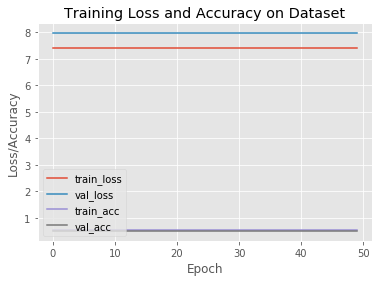

In [14]:
import matplotlib.pyplot as plt
import numpy as np
# plot the training loss and accuracy
N = epocas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")#Se guarda la gráfica en disco

### Gráficas con resultados del entrenamiento batch_size 32:

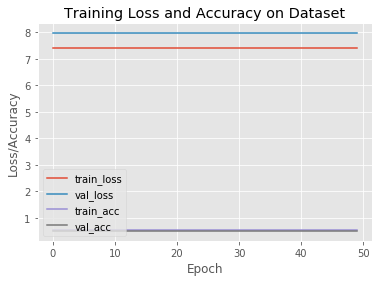

In [19]:
# plot the training loss and accuracy
N = epocas
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot2.png")#Se guarda la gráfica en disco

### Cálculo de la función pérdida:

El método evaluate_generator(generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0) se encarga de calcular la función de pérdida dados unos datos de entrada y el nivel de aciertos del modelo para una muestra dada.

In [15]:
score = model.evaluate_generator(validacion_generador, steps=pasos, verbose=1)
print('Test accuracy:', score[1])
print('Loss:', score[0])

10/10 [==============================] - 4s 369ms/step
Test accuracy: 0.5
Loss: 7.971192734582083


### Guardar el modelo entrenado:

Para no tener que entrenar la red neuronal creada cada vez que se quiera usar, se crea un archivo donde se guarda el modelo creado, y otro donde se guardan los pesos obtenidos para las neuronas después del entranmiento.

In [ ]:
import os 
dir = './InceptionResNetV2_OliGram_Prueba/'
if not os.path.exists(dir):
    os.mkdir(dir)
model.save('./InceptionResNetV2_OliGram_Prueba/modelo_InceptionResNetV2.h5')#Se guarda la estructura de la cnn
model.save_weights('./InceptionResNetV2_OliGram_Prueba/pesos_InceptionResNetV2.h5')#Se guardan los pesos de la cnn

### Pruebas de clasificación:

In [ ]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model

La función load_image() transforma de forma interna las imágenes, tomando como argumento las dimensiones que admiten las arquitecturas implementadas y un método de interpolación. Se recomienda usar métodos de interpolación como bicubic o lanczos, frente a nearest que viene por defecto.

In [ ]:
###Función predicción:
def predict(file):
  x = load_img(file, target_size=(altura, longitud))
  x = img_to_array(x)
  x = np.expand_dims(x, axis=0) #Zero mean pre-processing, normalize data.
  array = model.predict(x)
  print(array)  
  result = array[0]
  print(result)
  answer = np.argmax(result)
  print(answer)  
  if answer == 0:
    print("pred: Gramineas")
  elif answer == 1:
    print("pred: Olivo")
  return answer

In [ ]:
predict('olivo1.jpg') #Imagen de olivo

In [ ]:
predict('graminea2.jpg') #Imagen de graminea

In [ ]:
predict('WIN_20190625_21_13_02_Pro.jpg') #Imagen de graminea del dataset de entrenamiento

In [ ]:
predict('olivo4.jpg') #Imagen de olivo

In [ ]:
predict('olivo2.jpg') #Imagen de olivo

In [ ]:
predict('plot.png') #Imagen de

In [ ]:
x = load_img('graminea1.jpg', target_size=(altura, longitud))
x = img_to_array(x)
x = np.expand_dims(x, axis=0)
model.predict(x)

In [ ]:
print(entrenamiento_generador)